In [1]:
import numpy as np
import pandas as pd

from tasksim import *

from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.cluster import GaussianCluster as GMM
# from graspologic.cluster import AutoGMMCluster as GMM


from sklearn.metrics import normalized_mutual_info_score as NMI

import torchvision

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from joblib import Parallel, delayed
import pickle
import time
from tqdm import tqdm
import os

In [15]:
class Dataset:
    def __init__(self, file='cifar_100_Bit_m-r101x1_embd.p', train=True, classes=[]):
        if train:
            if file == 'data/cifar_100_Bit_m-r101x1_embd.p':
                self.data = pickle.load(open(file, 'rb'))[0][0]
                self.targets = np.concatenate(pickle.load(open(file, 'rb'))[0][1])
        else:
            if file == 'data/cifar_100_Bit_m-r101x1_embd.p':
                self.data = pickle.load(open(file, 'rb'))[1][0]
                self.targets = np.concatenate(pickle.load(open(file, 'rb'))[1][1])
        
        self.classes = classes

In [16]:
file = 'data/cifar_100_Bit_m-r101x1_embd.p'

# cif100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
trainset = Dataset(file, classes=cif100.classes)
# testset = Dataset(file, train=False, classes=cif100.classes)

Files already downloaded and verified


In [19]:
data_dimension=2048

if data_dimension < trainset.data.shape[1]:
    pca = PCA(n_components=data_dimension)
    pca.fit(trainset.data)
    trainset.data = pca.transform(trainset.data)
    testset.data = pca.transform(testset.data)

In [20]:
def evaluate_clusters(f, truth, preds, calculate_random=False, n_mc=500, acorn=None):
    eval_pred = f(truth, preds)
    
    if not calculate_random:
        return eval_pred
    
    eval_random = np.zeros(n_mc)
    for i in range(n_mc):
        shuffled_preds = np.random.choice(preds, size=len(preds), replace=False)
        eval_random[i] = f(truth, shuffled_preds)
        
    return eval_pred, np.mean(eval_random)

def evaluate_accuracy(data, labels, truth, preds, n_trees_coarse=25, n_trees_fine=10, train_flat=True,
                     test_data=None, test_labels=None, max_depth=5,
                     acorn=None):
    classes = np.unique(labels)
    
    forests_dict = {
            'coarse_truth': None, 
            'fine_truth': {c: None for c in np.unique(truth)},
            'coarse_preds': None,
            'fine_preds': {c: None for c in np.unique(preds)}, 
            'flat': None
    }
    
    # Coarse forest
    coarse_forest_truth = l2f(default_n_estimators=n_trees_coarse,
                        default_max_depth=max_depth)
    
    coarse_forest_truth.add_task(data, truth[labels])
    forests_dict['coarse_truth'] = coarse_forest_truth
    
    coarse_forest_preds = l2f(default_n_estimators=n_trees_coarse,
                        default_max_depth=max_depth)
    
    coarse_forest_preds.add_task(data, preds[labels])
    forests_dict['coarse_preds'] = coarse_forest_preds
    
    
    # Flat forest
    n_trees_flat = n_trees_coarse + len(np.unique(truth))*n_trees_fine
    
    if train_flat:
        flat_forest_truth = l2f(default_n_estimators=n_trees_flat,
                            default_max_depth=max_depth)
        flat_forest_truth.add_task(data, labels)
        forests_dict['flat'] = flat_forest_truth
        
    # Fine forest
    for j, parent_class in enumerate(np.unique(truth)):
        temp_fine_indices = np.where(truth[labels] == parent_class)[0]
        
        
        fine_forest_truth = l2f(default_n_estimators=n_trees_fine, 
                               default_max_depth=max_depth
                              )
        fine_forest_truth.add_task(data[temp_fine_indices], labels[temp_fine_indices])
        forests_dict['fine_truth'][j] = fine_forest_truth
        
    for j, parent_class in enumerate(np.unique(preds)):
        temp_fine_indices = np.where(preds[labels] == parent_class)[0]
        
        fine_forest_preds = l2f(default_n_estimators=n_trees_fine, 
                               default_max_depth=max_depth
                              )
        fine_forest_preds.add_task(data[temp_fine_indices], labels[temp_fine_indices])
        forests_dict['fine_preds'][j] = fine_forest_preds
        
        
    # Now, calculate accuracies
    accuracies = np.zeros(3)
    
    if test_data is None:
        raise ValueError
        
    n_test, d_test = test_data.shape
                
    hierarchical_posteriors_truth = np.zeros((n_test, len(classes)))
    hierarchical_posteriors_preds = np.zeros((n_test, len(classes)))
    
    coarse_posteriors_truth = forests_dict['coarse_truth'].predict_proba(test_data, 0)
    coarse_posteriors_preds = forests_dict['coarse_preds'].predict_proba(test_data, 0)
        
    # Hierarchical posteriors & prediction
    for j, parent_class in enumerate(np.unique(truth)):
        temp_fine_label_indices = np.where(truth == parent_class)[0]
        
        temp_fine_posteriors = forests_dict['fine_truth'][j].predict_proba(test_data, 0)
        hierarchical_posteriors_truth[:, temp_fine_label_indices] = np.multiply(coarse_posteriors_truth[:, j],
                                                                     temp_fine_posteriors.T
                                                                    ).T
        
    for j, parent_class in enumerate(np.unique(preds)):
        temp_fine_label_indices = np.where(preds == parent_class)[0]

        
        temp_fine_posteriors = forests_dict['fine_preds'][j].predict_proba(test_data, 0)
        hierarchical_posteriors_preds[:, temp_fine_label_indices] = np.multiply(coarse_posteriors_preds[:, j],
                                                                     temp_fine_posteriors.T
                                                                    ).T
        
    yhat_hc = np.argmax(hierarchical_posteriors_truth, axis=1)
    accuracies[0] = np.mean(yhat_hc == np.array(test_labels))
    
    yhat_hc = np.argmax(hierarchical_posteriors_preds, axis=1)
    accuracies[1] = np.mean(yhat_hc == np.array(test_labels))
    
    
    # Flat posteriors & prediction
    if train_flat:
        flat_posteriors = forests_dict['flat'].predict_proba(test_data, 0)
        yhat_flat = np.argmax(flat_posteriors, axis=1)
        accuracies[2] = np.mean(yhat_flat == np.array(test_labels))
    
    return accuracies[:, np.newaxis].T

In [21]:
def generate_results(X, y, X_test, y_test,
                    acc_kwargs,
                    eval_kwargs=None):
    
    acc_kwargs['test_data'] = X_test
    acc_kwargs['test_labels'] = y_test
    
    del X_test
    del y_test
    
    accs = evaluate_accuracy(X, y, **acc_kwargs)
    
    if eval_kwargs is not None:
        evals = evaluate_clusters(**eval_kwargs)
        return np.array(evals)[:, np.newaxis].T, accs
    
    return accs

In [22]:
def stratified_sample(idx_by_label, p=0.1, replace=False):
    return np.concatenate([np.random.choice(ibl, size=int(max([1, p * len(ibl)])), replace=replace) for ibl in idx_by_label])

In [23]:
coarse_to_fine_map = {
'aquatic_mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
'food_containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
'fruit_and_vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
'household_electrical_devices': ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
'household_furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
'large_carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
'large_man-made_outdoor_things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
'large_natural_outdoor_scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
'large_omnivores_and_herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
'medium-sized_mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
'non-insect_invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
'people': ['baby', 'boy', 'girl', 'man', 'woman'],
'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
'vehicles_1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
'vehicles_2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

coarse_number_to_coarse_name = {i: name for i, name in enumerate(coarse_to_fine_map)}

def fine_to_coarse(coarse_to_fine):
    fine_to_coarse_map = {}
    for key in coarse_to_fine:
        fines = coarse_to_fine[key]
        for f in fines:
            fine_to_coarse_map[f] = key
            
    return fine_to_coarse_map

fine_to_coarse_map = fine_to_coarse(coarse_to_fine_map)

fine_number_to_fine_name = {i: name for i, name in enumerate(trainset.classes)}
fine_name_to_fine_number = {name: i for i, name in fine_number_to_fine_name.items()}

for i in range(100):
    fine_to_coarse_map[fine_number_to_fine_name[i]]
    
coarse_name_to_coarse_number = {name: i for i, name in enumerate(coarse_to_fine_map)}

coarse_targets = np.array([coarse_name_to_coarse_number[fine_to_coarse_map[fine_number_to_fine_name[y]]] for y in trainset.targets])
idx_by_coarse = np.array([np.where(coarse_targets == y)[0] for y in range(20)])
idx_by_fine = np.array([np.where(trainset.targets == y)[0] for y in range(100)])


test_coarse_targets = np.array([coarse_name_to_coarse_number[fine_to_coarse_map[fine_number_to_fine_name[y]]] for y in testset.targets])
test_idx_by_coarse = np.array([np.where(test_coarse_targets == y)[0] for y in range(20)])


coarse_names = np.array(list(coarse_name_to_coarse_number.keys()))

fine_number_to_coarse_number = {fn: coarse_name_to_coarse_number[
                                        fine_to_coarse_map[
                                            fine_number_to_fine_name[fn]
                                        ]
                                    ] for fn in range(100)}


fine_by_coarse = [np.where(np.array(list(fine_number_to_coarse_number.values())) == i)[0] for i in range(20)]
all_fine = np.concatenate(fine_by_coarse)

In [34]:
np.random.seed(2)

n_props = [0.2, 0.4, 0.6, 0.8]

generate_dist_matrix_kwargs = {'metric':'tasksim', 
                               'metric_kwargs':{'n_neg_classes': 20, 
                                                'task_similarity_kwargs': {'transformer_kwargsx': 
                                                                               {'max_depth':4},
                                                                          'transformer_kwargsz':
                                                                              {'max_depth':4}}}, 
                               'function_tuples':None, 
                               'n_cores':30, 
                               'acorn':None
                              }

# generate_dist_matrix_kwargs = {'metric':'mmd', 
#                                'metric_kwargs':{'gamma': 'median'},
#                                'function_tuples':None,
#                                'n_cores':30, 
#                                'acorn':None
#                               }

process_dist_matrix_kwargs = {'make_symmetric': True,
                              'scale':True,
                             'aug_diag':True,
#                               'negate': True
                             }

embedding=ASE
embedding_kwargs={'n_components':16}
cluster=GMM
cluster_kwargs = {'max_components': 30, 
#                   'selection_criteria': 'aic', 
#                   'max_iter':10
                 }

cluster_dists_kwargs = {'embedding':embedding, 
                        'embedding_kwargs':embedding_kwargs, 
                        'cluster':cluster, 
                        'cluster_kwargs':cluster_kwargs
                       }

In [56]:
# NB: Setting n_mc = 2 and n_props = [0.2, 0.4, 0.6, 0.8] takes 9052 seconds = 2.5 hours to generate all the clusters

np.random.seed(2)
cluster_tuples = []
n_mc = 15
n_cores=30

for i, prop in enumerate(n_props):
    for j in range(n_mc):
        inds = stratified_sample(idx_by_fine, p=prop, replace=False)
        cluster_tuples.append((inds,
                                  generate_dist_matrix_kwargs, 
                                  process_dist_matrix_kwargs, 
                                  cluster_dists_kwargs, 
                                  max([1, int(n_cores / n_mc)])
                              ))

use_stored_clusters = True

if use_stored_clusters:
    clusters = pickle.load(open('newest_clusters.pkl', 'rb'))
else:
    condensed_func_clusters = lambda x: generate_hierarchy(trainset.data[x[0]], trainset.targets[x[0]],
                                                          *x[1:])
    start_time = time.time()
    clusters = Parallel(n_jobs=n_cores)(delayed(condensed_func_clusters)(tuple_) for tuple_ in cluster_tuples)
    clocked = time.time() - start_time
    print(clocked)
    pickle.dump(clusters, open('newest_clusters.pkl', 'wb'))

20000


In [42]:
f=NMI
truth = np.array(list(fine_number_to_coarse_number.values()))

evals = np.zeros((len(n_props), 2, n_mc))

for i, clust_ in enumerate(clusters):
    n_mc_idx = i % n_mc
    n_prop_idx = np.math.floor(i / n_mc)
    evals[n_prop_idx, :, n_mc_idx] = evaluate_clusters(f, truth, clust_, calculate_random=True, n_mc=1000)

In [ ]:
sdf

In [23]:
np.random.seed(1)

f=NMI
truth = np.array(list(fine_number_to_coarse_number.values()))
calculate_random=True
random_nmc=500
eval_kwargs = (f, truth, calculate_random, random_nmc)

n_trees_coarse=500
n_trees_fine=100
train_flat=False
max_depth=5

acc_kwargs = (n_trees_coarse, n_trees_fine, train_flat, testset.data, testset.targets, max_depth)

results_tuples = []
for i, cluster in enumerate(clusters):
    inds = cluster_tuples[i][0]
    eval_kwargs = {'f': f,
                   'truth': truth,
                   'preds': cluster,
                   'calculate_random': True,
                   'n_mc': random_nmc}
    acc_kwargs = {'truth':truth, 
                  'preds': cluster,
                  'n_trees_coarse':n_trees_coarse, 
                  'n_trees_fine':n_trees_fine, 
                  'train_flat':train_flat,
                  'max_depth':max_depth,
                }
    results_tuples.append((inds, acc_kwargs, eval_kwargs))

In [133]:
np.random.seed(1)

f=NMI
truth = np.array(list(fine_number_to_coarse_number.values()))
calculate_random=True
random_nmc=1000
eval_kwargs = (f, truth, calculate_random, random_nmc)

n_trees_coarse=500
n_trees_fine=100
train_flat=False
max_depth=5

acc_kwargs = (n_trees_coarse, n_trees_fine, train_flat, testset.data, testset.targets, max_depth)

results_tuples = []
for i, cluster in enumerate(clusters):
    inds = cluster_tuples[i][0]
    eval_kwargs = {'f': f,
                   'truth': truth,
                   'preds': cluster,
                   'calculate_random': True,
                   'n_mc': random_nmc}
    acc_kwargs = {'truth':truth, 
                  'preds': cluster,
                  'n_trees_coarse':n_trees_coarse, 
                  'n_trees_fine':n_trees_fine, 
                  'train_flat':train_flat,
                  'max_depth':max_depth,
                }
    results_tuples.append((inds, acc_kwargs, eval_kwargs))
    
condensed_func_results = lambda x: generate_results(trainset.data[x[0]], trainset.targets[x[0]],
                                                   testset.data, np.array(testset.targets),
                                                   x[1], 
                                                   x[2])
    
results = Parallel(n_jobs=n_cores)(delayed(condensed_func_results)(tuple_) for tuple_ in results_tuples)

In [40]:
n_per_prop = int(len(results) / len(n_props))

evals = np.zeros((len(n_props), 2, n_per_prop))
# accs = np.zeros((len(n_props), 3, n_per_prop))

for _, list_ in enumerate(results):
    n_mc_idx = _ % n_per_prop
    prop_idx = int(np.floor((_ / n_per_prop)))
    evals[prop_idx,:,n_mc_idx]=list_[0]
#     accs[prop_idx,:,n_mc_idx]=list_[1]

NameError: name 'results' is not defined

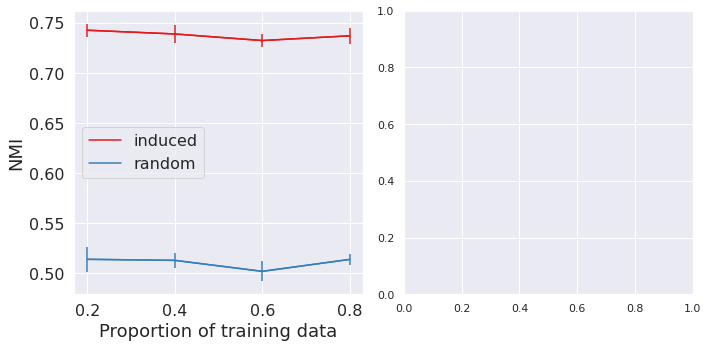

In [53]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

colors = sns.color_palette("Set1", n_colors=3)

# mean_accs = np.mean(accs, axis=-1)
mean_evals = np.mean(evals, axis=-1)
std_evals = np.std(evals, axis=-1, ddof=0) / np.sqrt(n_mc)

ax[0].plot(n_props, mean_evals[:,0], label='induced', c=colors[0])
ax[0].plot(n_props, mean_evals[:,1], label='random', c=colors[1])
ax[0].errorbar(n_props, mean_evals[:,0], yerr=1.96*std_evals[:,0], c=colors[0])
ax[0].errorbar(n_props, mean_evals[:,1], yerr=1.96*std_evals[:,1], c=colors[1])


ax[0].legend(loc='center left', fontsize=16)

ax[0].set_xticks(n_props)
# ax[1].set_yticks([0.32, 0.34, 0.36, 0.38])
# ax[1].set_ylim(0.31, 0.381)
# ax[1].set_ylabel('Accuracy')
ax[0].set_xlabel('Proportion of training data', fontsize=18)
ax[0].set_ylabel('NMI', fontsize=18)
ax[0].tick_params(labelsize=16)
# ax[0].set_yticks([0.12, 0.16, 0.20, 0.24])

algs = ['truth', 'induced', 'flat']

colors = sns.color_palette('Set1', n_colors=3)

# ax[1].plot(n_props, mean_accs[:,1], label='induced', c=colors[0])
# ax[1].plot(n_props, mean_accs[:,0], label='truth', c=colors[2])

# ax[1].plot(n_props, mean_accs[:,2], label='flat', c=colors[1])
# ax[1].legend(loc='center left', fontsize=16)

# ax[1].set_xticks(n_props)
# # ax[1].set_yticks([0.32, 0.34, 0.36, 0.38])
# # ax[1].set_ylim(0.31, 0.381)
# ax[1].set_ylabel('Accuracy', fontsize=18)
# ax[1].set_xlabel('Proportion of training data', fontsize=18)
# ax[1].tick_params(labelsize=16)

plt.tight_layout()

1981.8712391853333


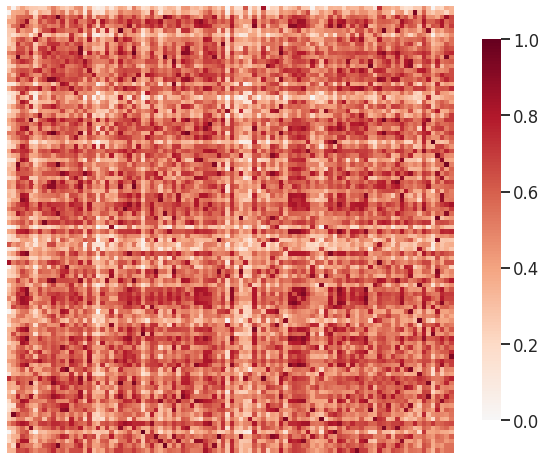

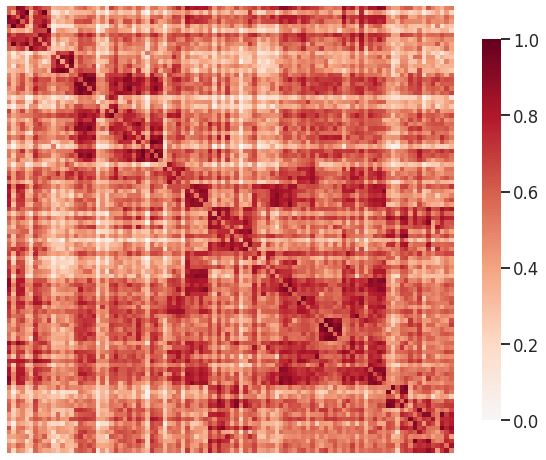

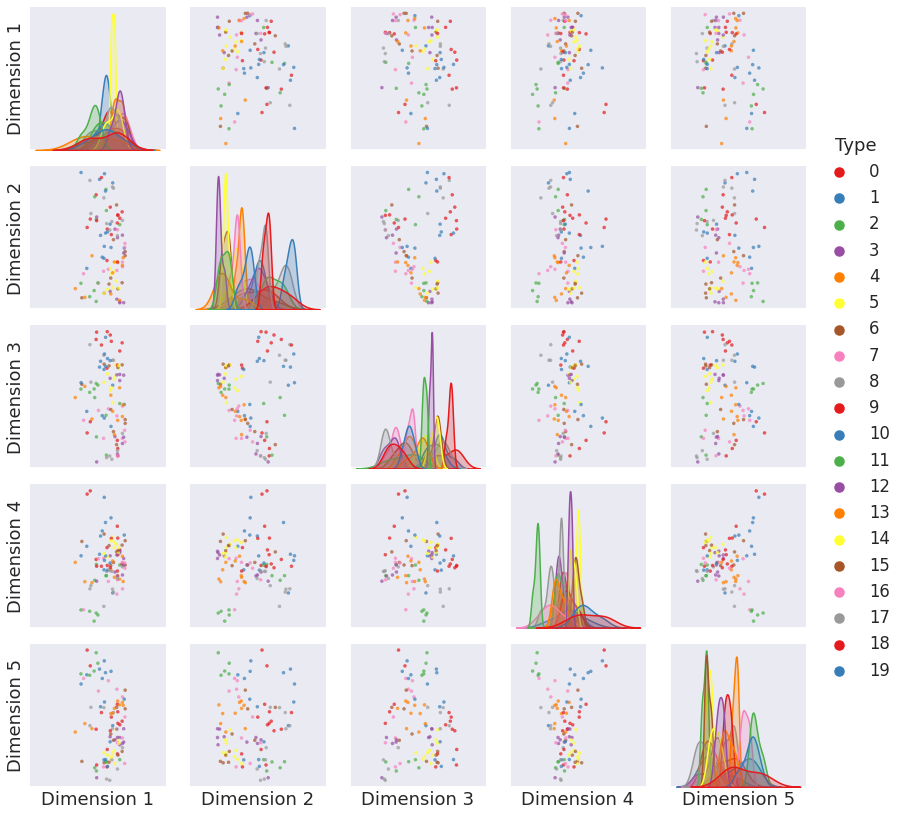

In [28]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import pairwise_distances
from graspologic.plot import heatmap, pairplot

inds = stratified_sample(idx_by_fine, p=0.2)
start_time = time.time()

dist_matrix = generate_dist_matrix(trainset.data[inds], trainset.targets[inds], **generate_dist_matrix_kwargs)

elapsed_time = time.time() - start_time
print(elapsed_time)
heatmap(preprocess_dist_matrix(dist_matrix, True, True, True))

from graspologic.plot import heatmap

b = np.zeros((100, 100))
b[:, np.arange(100)] = dist_matrix[:, all_fine]
b[np.arange(100), :] = b[all_fine, :]

heatmap(preprocess_dist_matrix(b, make_symmetric=True, aug_diag=True, scale=True))
X_hat = ASE(n_components=16).fit_transform(preprocess_dist_matrix(dist_matrix, make_symmetric=True, aug_diag=True, scale=True))

from graspologic.plot import pairplot

n_classes=20

pairplot(X_hat[:5 * n_classes, :5], labels=list(fine_number_to_coarse_number.values()))

clust_preds = GMM(max_components=30).fit_predict(X_hat)

In [31]:
f=NMI
truth = np.array(list(fine_number_to_coarse_number.values()))

for i, c in enumerate(np.unique(clust_preds)):
    ix = np.where(clust_preds == c)[0]
    print(np.array(list(fine_name_to_fine_number))[ix])
    
evaluate_clusters(f, truth, clust_preds, calculate_random=True, n_mc=500)

['bed' 'can' 'clock' 'table' 'television']
['bear' 'beaver' 'camel' 'crocodile' 'dinosaur' 'flatfish' 'mouse' 'otter'
 'possum' 'seal' 'shrew' 'turtle']
['bee' 'beetle' 'butterfly' 'caterpillar' 'cockroach' 'crab' 'lizard'
 'lobster' 'mushroom' 'snail' 'snake' 'spider' 'worm']
['bridge' 'bus' 'house' 'rocket' 'skyscraper' 'tank']
['apple' 'orange']
['orchid' 'poppy' 'rose' 'sunflower' 'tulip']
['bottle' 'bowl' 'couch' 'cup' 'keyboard' 'lamp' 'motorcycle' 'pear'
 'plate' 'sweet_pepper' 'telephone']
['dolphin' 'whale']
['bicycle' 'lawn_mower' 'streetcar' 'tractor']
['forest' 'maple_tree' 'pine_tree' 'plain' 'willow_tree']
['cloud' 'mountain' 'sea']
['baby']
['cattle' 'elephant']
['chair']
['castle' 'oak_tree' 'palm_tree' 'pickup_truck' 'road' 'train']
['chimpanzee' 'fox' 'hamster' 'kangaroo' 'leopard' 'lion' 'porcupine'
 'rabbit' 'raccoon' 'skunk' 'squirrel' 'tiger' 'wolf']
['wardrobe']
['ray' 'shark' 'trout']
['aquarium_fish']
['boy']
['girl' 'man' 'woman']


(0.7154137030661322, 0.45618547611016347)